**features**:

num_stays: total number of unit stays

stay_length: total length of unit stays (use service mean stay length to impute)

stay_min: the min stay length of all admissions

stay_max: the max stay length of all admissions

stay_std: the std of stay length

stay_mean: the mean stay length

num_unique_services: number of unique services

num_transfer: number of admission transfers (different discharge and admission unit)

num_cvd_readmission: number of readmissions that are caused by cardiovascular

CVD: whether the patient has a cardiovescular diagnosis (0/1)

*Different Service name*: number of times they stay in this unit

*Different Specialty name*: number of times they stay in this specialty

*Different Age bins*: number of unit stays within this age range

age_mean: the mean admission age for each patient

age_std: the std of the admission age for each patient

age_min: the min age among all admissions

age_max: the max age among all admissions

freq: the frequency of admissions per year

readmission: whether this patient has ever been admitted again (0/1) (target)

died: whether this patient is dead or not (target)

AO: whether this patinet has been exposed to Agentorange

unique_admitting_specialty: (hasn't tidied the specialty)

unique_discharging_specialty: (hasn't tidied the specialty)

Age_min

Age_max

Stay_length: mean, std, min, max

We'll not consider location dataset anymore

In [4]:
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [5]:
datatype = "test"

In [6]:
if datatype == "train": 
    DATA_PATH = "../../../../bhatti/dataset/VCHAMPS"
    dataset_path = 'inpatient_admissions_train.csv'
elif datatype == "quality":
    DATA_PATH = '/data/public/MLA/VCHAMPS-Quality/'
    dataset_path = "inpatient_admissions_qual_Formatfixed.csv"
else: 
    DATA_PATH = '/data/public/MLA/VCHAMPS-Test/'
    dataset_path = "inpatient_admissions_test.csv"
load_path = os.path.join(DATA_PATH, dataset_path)
in_ad = pd.read_csv(load_path,index_col=0)
in_ad

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,Discharge disposition,Died during admission,Outpatientreferralflag,Serviceconnectedflag,Agentorangeflag,State
14,100041,83.927801,2009-03-09 14:40:14.0,2009-03-20 14:25:08.0,MEDICINE,SURGERY,HALFWAY HOUSE,Not specified (no value),Atherosclerotic heart disease of native corona...,Unstable angina,Regular,No,Yes,NaN,NaN,Minnesota
18,10005,49.697229,2001-04-30 08:05:33.0,2001-05-01 10:13:18.0,MEDICINE,MEDICINE,REHABILITATION MEDICINE,TELEMETRY,Other chest pain,Pure hypercholesterolemia,Regular,No,Yes,No,NaN,Michigan
33,100106,65.239819,2015-04-13 03:41:17.0,2015-04-14 19:59:28.0,MEDICINE,MEDICINE,DOD BEDS IN VA FACILITY,GENERAL(ACUTE MEDICINE),"Anemia, unspecified",Unspecified protein-calorie malnutrition,Regular,No,Yes,NaN,No,Ohio
34,100123,65.905689,2006-09-28 12:42:05.0,2006-10-30 19:14:57.0,NHCU,NHCU,NH LONG-STAY CONTINUING CARE,NH SHORT STAY REHABILITATION,Encounter for other specified aftercare,Unspecified atrial fibrillation and atrial flu...,Regular,No,Yes,No,No,Oklahoma
35,100126,71.818960,2020-11-23 19:55:17.0,2020-11-25 21:16:25.0,MEDICINE,MEDICINE,HALFWAY HOUSE,GENERAL(ACUTE MEDICINE),Burkitt lymphoma,Secondary malignant neoplasm of lung,Regular,No,Yes,NaN,No,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665801,99850,73.529082,2016-06-19 21:06:27.0,2016-06-22 04:17:40.0,SURGERY,SURGERY,SURGICAL STEPDOWN,SURGICAL ICU,"Benign neoplasm of colon, unspecified",Non-ST elevation (NSTEMI) myocardial infarction,Transfer,No,No,NaN,No,Nevada
665805,99861,77.926770,2002-09-27 05:37:30.0,2002-10-16 06:58:24.0,MEDICINE,INTERMEDIATE MED,SPINAL CORD INJURY OBSERVATION,INTERMEDIATE MEDICINE,"Chronic obstructive pulmonary disease, unspeci...","Finding of other specified substances, not nor...",Regular,No,Yes,NaN,No,Louisiana
665815,99883,58.530994,2001-10-23 01:52:50.0,2001-10-24 03:37:33.0,NON-COUNT,NON-COUNT,GRECC-GEM-REHAB,MEDICAL OBSERVATION,Other restrictive cardiomyopathy,Not specified,Regular,No,Yes,NaN,No,Texas
665824,99920,65.035879,2003-10-02 14:43:38.0,2003-10-08 06:12:01.0,MEDICINE,MEDICINE,SPINAL CORD INJURY,GENERAL(ACUTE MEDICINE),"Cutaneous abscess, furuncle and carbuncle of l...",Unspecified atrial fibrillation and atrial flu...,Regular,No,Yes,No,NaN,Oregon


In [7]:
if datatype == "quality":
    in_ad.rename(columns = {'Age.at.admission': "Age at admission", "Admission.date": "Admission date", "Discharge.date": "Discharge date",
                            "Admitting.unit.service": "Admitting unit service", "Discharging.unit.service": "Discharging unit service",
                            "Admitting.specialty": "Admitting specialty", "Discharging.specialty": "Discharging specialty", 
                            "First.listed.discharge.diagnosis.icd10.subcategory": "First listed discharge diagnosis icd10 subcategory",
                            "Second.listed.discharge.diagnosis.icd10.subcategory": "First listed discharge diagnosis icd10 subcategory",
                            "Discharge.disposition": "Discharge disposition", "Died.during.admission": "Died during admission"}, inplace = True)

### Died at location

In [8]:
in_ad["Died during admission"] = in_ad["Died during admission"].replace({"Yes":1, "No": 0})
in_ad["Agentorangeflag"] = in_ad["Agentorangeflag"].replace({"Yes":1, "No": 0})

### Num transfers

In [9]:
in_ad['Transfer'] = [0] * len(in_ad)
def transfer(data):
    data.loc[data['Admitting unit service'] != data['Discharging unit service'], 'Transfer'] = 1
    return data
in_ad = transfer(in_ad)

### Regrouping Admitting Unit Serivice

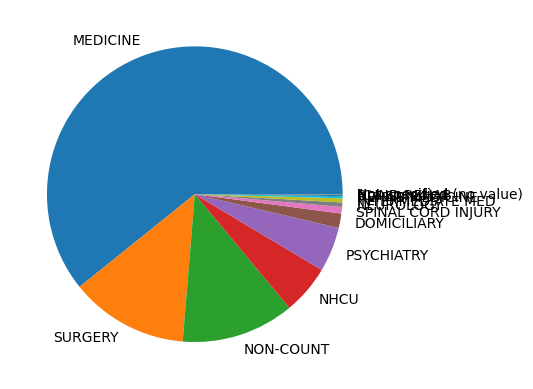

In [10]:
plt.pie(in_ad["Admitting unit service"].value_counts(), labels = in_ad["Admitting unit service"].value_counts().index);

In [11]:
in_ad["Admitting unit service"].unique()

array(['MEDICINE', 'NHCU', 'PSYCHIATRY', 'NON-COUNT', 'SURGERY',
       'SPINAL CORD INJURY', 'NEUROLOGY', 'DOMICILIARY',
       'INTERMEDIATE MED', 'BLIND REHAB', 'REHAB MEDICINE', '(Censored)',
       'Not specified (no value)', 'Not specified'], dtype=object)

In [12]:
in_ad["Admitting unit service"] = in_ad["Admitting unit service"].replace({'REHAB MEDICINE':'OTHERS', 'BLIND REHAB':'OTHERS',
                                        '(Censored)':'NON-COUNT', 'Not specified (no value)':'NON-COUNT', 'Not specified':'NON-COUNT',
                                        'INTERMEDIATE MED':'OTHERS', 'NEUROLOGY':'OTHERS', 'SPINAL CORD INJURY':'OTHERS'})
in_ad = pd.concat([in_ad, pd.get_dummies(in_ad['Admitting unit service'])], axis=1)

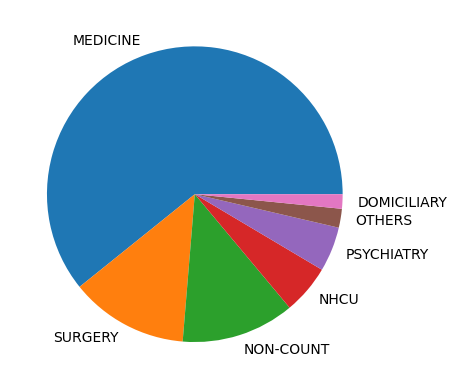

In [13]:
plt.pie(in_ad["Admitting unit service"].value_counts(), labels = in_ad["Admitting unit service"].value_counts().index);

### Length of Stay

In [14]:
admission_stay_length = []
for i, row in in_ad.iterrows():
    start = row["Admission date"]
    end = row["Discharge date"]

    start = pd.to_datetime(start,
               format='%Y-%m-%d %H:%M:%S.%f')
    end = pd.to_datetime(end,
               format='%Y-%m-%d %H:%M:%S.%f')
    
    diff = pd.Timedelta(end - start).days
    diff += round(pd.Timedelta(end - start).seconds/3600/24,2)

    admission_stay_length.append(diff)

in_ad["stay_length"] = admission_stay_length # in terms of day

#### Imputation

In [15]:
mean_stay_length = in_ad.groupby("Admitting unit service")["stay_length"].mean()
nan_admission = in_ad[in_ad["stay_length"].isna()]
in_ad = in_ad[~in_ad["stay_length"].isna()]

In [16]:
admission_stay_length = []
for i, row in nan_admission.iterrows():
    service = row["Admitting unit service"]
    diff = mean_stay_length[service]

    admission_stay_length.append(round(diff,2))

nan_admission["stay_length"] = admission_stay_length

In [17]:
in_ad = pd.concat([in_ad, nan_admission])
in_ad

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,...,State,Transfer,DOMICILIARY,MEDICINE,NHCU,NON-COUNT,OTHERS,PSYCHIATRY,SURGERY,stay_length
14,100041,83.927801,2009-03-09 14:40:14.0,2009-03-20 14:25:08.0,MEDICINE,SURGERY,HALFWAY HOUSE,Not specified (no value),Atherosclerotic heart disease of native corona...,Unstable angina,...,Minnesota,1,0,1,0,0,0,0,0,10.99
18,10005,49.697229,2001-04-30 08:05:33.0,2001-05-01 10:13:18.0,MEDICINE,MEDICINE,REHABILITATION MEDICINE,TELEMETRY,Other chest pain,Pure hypercholesterolemia,...,Michigan,0,0,1,0,0,0,0,0,1.09
33,100106,65.239819,2015-04-13 03:41:17.0,2015-04-14 19:59:28.0,MEDICINE,MEDICINE,DOD BEDS IN VA FACILITY,GENERAL(ACUTE MEDICINE),"Anemia, unspecified",Unspecified protein-calorie malnutrition,...,Ohio,0,0,1,0,0,0,0,0,1.68
34,100123,65.905689,2006-09-28 12:42:05.0,2006-10-30 19:14:57.0,NHCU,NHCU,NH LONG-STAY CONTINUING CARE,NH SHORT STAY REHABILITATION,Encounter for other specified aftercare,Unspecified atrial fibrillation and atrial flu...,...,Oklahoma,0,0,0,1,0,0,0,0,32.27
35,100126,71.818960,2020-11-23 19:55:17.0,2020-11-25 21:16:25.0,MEDICINE,MEDICINE,HALFWAY HOUSE,GENERAL(ACUTE MEDICINE),Burkitt lymphoma,Secondary malignant neoplasm of lung,...,California,0,0,1,0,0,0,0,0,2.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650905,86951,64.998583,2022-11-28 23:34:20.0,NaN,MEDICINE,MEDICINE,DOD BEDS IN VA FACILITY,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,Ohio,0,0,1,0,0,0,0,0,5.93
658056,80003,79.253877,2023-08-21 07:00:46.0,NaN,OTHERS,SPINAL CORD INJURY,LONG TERM PSYCHIATRY(>45 DAYS),SPINAL CORD INJURY,Quadriplegia,Not specified,...,Ohio,0,0,0,0,0,1,0,0,21.46
662481,90207,82.605395,2020-03-22 06:31:36.0,NaN,NHCU,NHCU,NH SHORT-STAY CONTINUING CARE,NH SHORT STAY REHABILITATION,Weakness,Infection and inflammatory reaction due to pro...,...,Oregon,0,0,0,1,0,0,0,0,100.75
663122,93036,67.074095,2015-01-28 13:57:36.0,NaN,NON-COUNT,Not specified (no value),Not specified,Not specified,Not specified,Not specified,...,Texas,0,0,0,0,1,0,0,0,1.92


### Age at admission

Divide to different age bins: (20-40], (40-60], (60-80], (80-100], (100-120]

In [18]:
print(in_ad["Age at admission"].min())
print(in_ad["Age at admission"].max())

20.699887077570043
108.11996633860262


In [19]:
in_ad['Age 20-40'] = [0] * len(in_ad)
in_ad['Age 40-60'] = [0] * len(in_ad)
in_ad['Age 60-80'] = [0] * len(in_ad)
in_ad['Age 80-100'] = [0] * len(in_ad)
in_ad['Age 100-120'] = [0] * len(in_ad)
def age_category(data):
    data.loc[(data['Age at admission'] > 20) & (data['Age at admission'] <= 40), 'Age 20-40'] = 1
    data.loc[(data['Age at admission'] > 40) & (data['Age at admission'] <= 60), 'Age 40-60'] = 1
    data.loc[(data['Age at admission'] > 60) & (data['Age at admission'] <= 80), 'Age 60-80'] = 1
    data.loc[(data['Age at admission'] > 80) & (data['Age at admission'] <= 100), 'Age 80-100'] = 1
    data.loc[(data['Age at admission'] > 100) & (data['Age at admission'] <= 120), 'Age 100-120'] = 1
    return data
in_ad = age_category(in_ad)
in_ad

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,...,NON-COUNT,OTHERS,PSYCHIATRY,SURGERY,stay_length,Age 20-40,Age 40-60,Age 60-80,Age 80-100,Age 100-120
14,100041,83.927801,2009-03-09 14:40:14.0,2009-03-20 14:25:08.0,MEDICINE,SURGERY,HALFWAY HOUSE,Not specified (no value),Atherosclerotic heart disease of native corona...,Unstable angina,...,0,0,0,0,10.99,0,0,0,1,0
18,10005,49.697229,2001-04-30 08:05:33.0,2001-05-01 10:13:18.0,MEDICINE,MEDICINE,REHABILITATION MEDICINE,TELEMETRY,Other chest pain,Pure hypercholesterolemia,...,0,0,0,0,1.09,0,1,0,0,0
33,100106,65.239819,2015-04-13 03:41:17.0,2015-04-14 19:59:28.0,MEDICINE,MEDICINE,DOD BEDS IN VA FACILITY,GENERAL(ACUTE MEDICINE),"Anemia, unspecified",Unspecified protein-calorie malnutrition,...,0,0,0,0,1.68,0,0,1,0,0
34,100123,65.905689,2006-09-28 12:42:05.0,2006-10-30 19:14:57.0,NHCU,NHCU,NH LONG-STAY CONTINUING CARE,NH SHORT STAY REHABILITATION,Encounter for other specified aftercare,Unspecified atrial fibrillation and atrial flu...,...,0,0,0,0,32.27,0,0,1,0,0
35,100126,71.818960,2020-11-23 19:55:17.0,2020-11-25 21:16:25.0,MEDICINE,MEDICINE,HALFWAY HOUSE,GENERAL(ACUTE MEDICINE),Burkitt lymphoma,Secondary malignant neoplasm of lung,...,0,0,0,0,2.06,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650905,86951,64.998583,2022-11-28 23:34:20.0,NaN,MEDICINE,MEDICINE,DOD BEDS IN VA FACILITY,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,0,0,0,5.93,0,0,1,0,0
658056,80003,79.253877,2023-08-21 07:00:46.0,NaN,OTHERS,SPINAL CORD INJURY,LONG TERM PSYCHIATRY(>45 DAYS),SPINAL CORD INJURY,Quadriplegia,Not specified,...,0,1,0,0,21.46,0,0,1,0,0
662481,90207,82.605395,2020-03-22 06:31:36.0,NaN,NHCU,NHCU,NH SHORT-STAY CONTINUING CARE,NH SHORT STAY REHABILITATION,Weakness,Infection and inflammatory reaction due to pro...,...,0,0,0,0,100.75,0,0,0,1,0
663122,93036,67.074095,2015-01-28 13:57:36.0,NaN,NON-COUNT,Not specified (no value),Not specified,Not specified,Not specified,Not specified,...,1,0,0,0,1.92,0,0,1,0,0


### Cardiovascular

In [20]:
cardiovascular = ["Heart failure, unspecified", "Other heart failure",
                  "Cardiogenic shock", "Hypertensive heart disease with heart failure",
                  "Hypertensive heart and kidney disease with heart failure", "Unstable angina", "Other forms of chronic ischemic heart disease",
                  "Atherosclerotic heart disease of native coronary artery", "Atrial fibrillation", "Atrial flutter",
                  "Supraventricular tachycardia", "Ventricular tachycardia"]

In [21]:
in_ad["cd_diagnosis"] = [0] * len(in_ad)
def cd_diagnosis(data):
    data.loc[(in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains('|'.join(cardiovascular))
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Systolic (congestive) heart failure", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Diastolic (congestive) heart failure", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Combined systolic (congestive) and diastolic (congestive) heart failure", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("ST elevation (STEMI) myocardial infarction", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Non-ST elevation (NSTEMI) myocardial infarction", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains('|'.join(cardiovascular))
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Systolic (congestive) heart failure", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Diastolic (congestive) heart failure", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Combined systolic (congestive) and diastolic (congestive) heart failure", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("ST elevation (STEMI) myocardial infarction", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Non-ST elevation (NSTEMI) myocardial infarction", regex=False)), "cd_diagnosis"] = 1
    return data
in_ad = cd_diagnosis(in_ad)
in_ad


,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,...,OTHERS,PSYCHIATRY,SURGERY,stay_length,Age 20-40,Age 40-60,Age 60-80,Age 80-100,Age 100-120,cd_diagnosis
14,100041,83.927801,2009-03-09 14:40:14.0,2009-03-20 14:25:08.0,MEDICINE,SURGERY,HALFWAY HOUSE,Not specified (no value),Atherosclerotic heart disease of native corona...,Unstable angina,...,0,0,0,10.99,0,0,0,1,0,1
18,10005,49.697229,2001-04-30 08:05:33.0,2001-05-01 10:13:18.0,MEDICINE,MEDICINE,REHABILITATION MEDICINE,TELEMETRY,Other chest pain,Pure hypercholesterolemia,...,0,0,0,1.09,0,1,0,0,0,0
33,100106,65.239819,2015-04-13 03:41:17.0,2015-04-14 19:59:28.0,MEDICINE,MEDICINE,DOD BEDS IN VA FACILITY,GENERAL(ACUTE MEDICINE),"Anemia, unspecified",Unspecified protein-calorie malnutrition,...,0,0,0,1.68,0,0,1,0,0,0
34,100123,65.905689,2006-09-28 12:42:05.0,2006-10-30 19:14:57.0,NHCU,NHCU,NH LONG-STAY CONTINUING CARE,NH SHORT STAY REHABILITATION,Encounter for other specified aftercare,Unspecified atrial fibrillation and atrial flu...,...,0,0,0,32.27,0,0,1,0,0,0
35,100126,71.818960,2020-11-23 19:55:17.0,2020-11-25 21:16:25.0,MEDICINE,MEDICINE,HALFWAY HOUSE,GENERAL(ACUTE MEDICINE),Burkitt lymphoma,Secondary malignant neoplasm of lung,...,0,0,0,2.06,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650905,86951,64.998583,2022-11-28 23:34:20.0,NaN,MEDICINE,MEDICINE,DOD BEDS IN VA FACILITY,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,0,0,5.93,0,0,1,0,0,0
658056,80003,79.253877,2023-08-21 07:00:46.0,NaN,OTHERS,SPINAL CORD INJURY,LONG TERM PSYCHIATRY(>45 DAYS),SPINAL CORD INJURY,Quadriplegia,Not specified,...,1,0,0,21.46,0,0,1,0,0,0
662481,90207,82.605395,2020-03-22 06:31:36.0,NaN,NHCU,NHCU,NH SHORT-STAY CONTINUING CARE,NH SHORT STAY REHABILITATION,Weakness,Infection and inflammatory reaction due to pro...,...,0,0,0,100.75,0,0,0,1,0,0
663122,93036,67.074095,2015-01-28 13:57:36.0,NaN,NON-COUNT,Not specified (no value),Not specified,Not specified,Not specified,Not specified,...,0,0,0,1.92,0,0,1,0,0,0


In [22]:
in_ad.columns

Index(['Internalpatientid', 'Age at admission', 'Admission date',
       'Discharge date', 'Admitting unit service', 'Discharging unit service',
       'Admitting specialty', 'Discharging specialty',
       'First listed discharge diagnosis icd10 subcategory',
       'Second listed discharge diagnosis icd10 subcategory',
       'Discharge disposition', 'Died during admission',
       'Outpatientreferralflag', 'Serviceconnectedflag', 'Agentorangeflag',
       'State', 'Transfer', 'DOMICILIARY', 'MEDICINE', 'NHCU', 'NON-COUNT',
       'OTHERS', 'PSYCHIATRY', 'SURGERY', 'stay_length', 'Age 20-40',
       'Age 40-60', 'Age 60-80', 'Age 80-100', 'Age 100-120', 'cd_diagnosis'],
      dtype='object')

### Specialty

In [23]:
sub_abuse_and_mental = ['DRUG DEPENDENCE TRMT UNIT', 'PSYCHIATRIC MENTALLY INFIRM', 'SUBSTANCE ABUSE RES TRMT PROG', 'PLASTIC SURGERY', 'PSYCH RESID REHAB TRMT PROG', 'SUBSTANCE ABUSE INTERMED CARE', 'ACUTE PSYCHIATRY (<45 DAYS)', 'DOMICILIARY PTSD', 
                        'ALCOHOL DEPENDENCE TRMT UNIT', 'EVAL/BRF TRMT PTSD UNIT(EBTPU)', 'PTSD RESID REHAB PROG', 'PSYCH RESID REHAB PROG', 'PTSD CWT/TR', 
                        'PTSD RESIDENTIAL REHAB PROG', 'SUBST ABUSE STAR I, II & III', 'SUBSTANCE ABUSE TRMT UNIT', 'GEN INTERMEDIATE PSYCH', 'LONG TERM PSYCHIATRY(>45 DAYS)', 'SUBSTANCE ABUSE RESID PROG', 
                        'DOMICILIARY SUBSTANCE ABUSE', 'SIPU (SPEC INPT PTSD UNIT)', 'ZZALCOHOL DEPENDENCE TRMT UNIT', 'ZZSUBSTANCE ABUSE INTERMEDCARE', 'PSYCHIATRY', 'ZZDRUG DEPENDENCE TRMT UNIT',
                        'ZZSUBSTANCE ABUSE TRMT UNIT', 'GEN MEDICINE (ACUTE)', 'zSUBST ABUSE STAR I, II & III', 'ZZSUBST ABUSE STAR I,II,II', 'SUBST ABUSE CWT/TRANS RESID', 'HIGH INTENSITY GEN PSYCH INPAT', 'HALFWAY HOUSE']
medical = ['HEMATOLOGY/ONCOLOGY', 'GASTROENTEROLOGY', 'INTERMEDIATE MEDICINE', 'ANESTHESIOLOGY', 'PROCTOLOGY', 'CARDIAC SURGERY', 'TRANSPLANTATION', 'CARDIOLOGY', 'METABOLIC',
           'GENERAL(ACUTE MEDICINE)', 'PEDIATRICS', 'VASCULAR', 'OPHTHALMOLOGY', 'NEUROSURGERY', 'SURGICAL STEPDOWN', 'UROLOGY', 'PULMONARY, TUBERCULOSIS', 'PERIPHERAL VASCULAR', 
           'THORACIC SURGERY', 'MEDICAL STEP DOWN', 'GENERAL SURGERY', 'PULMONARY, NON-TB', 'EPILEPSY CENTER', 'NEUROLOGY', 'SPINAL CORD INJURY', 'ORAL SURGERY',
           'PODIATRY', 'EAR, NOSE, THROAT (ENT)', 'ENDOCRINOLOGY', 'CARDIAC-STEP DOWN UNIT', 'TELEMETRY', 'OB/GYN', 'ORTHOPEDIC', 'DOMICILIARY','ALLERGY', 'STROKE UNIT', 'DERMATOLOGY',
           'CARDIAC INTENSIVE CARE UNIT', 'HOSPICE FOR ACUTE CARE', 'SURGICAL ICU', 'MEDICAL ICU']
rehab = ['NH SHORT STAY REHABILITATION', 'BLIND REHAB OBSERVATION', 'BLIND REHAB', 'NH LONG STAY DEMENTIA CARE', 'NH SHORT-STAY CONTINUING CARE', 'NH HOSPICE', 'NEUROLOGY OBSERVATION', 'NH LONG-STAY MH RECOVERY', 
         'NH SHORT-STAY MH RECOVERY', 'NH SHORT STAY RESTORATIVE', 'REHABILITATION MEDICINE','NH SHORT STAY DEMENTIA CARE', 'RESPITE CARE (MEDICINE)', 'PM&R TRANSITIONAL REHAB', 
         'SPINAL CORD INJURY OBSERVATION', 'POLYTRAUMA REHAB UNIT', 'SURGICAL OBSERVATION', 'NHCU', 'NH SHORT STAY SKILLED NURSING', 'NH GEM NURSING HOME CARE', 'NH LONG STAY SKILLED NURSING', 'NH LONG-STAY CONTINUING CARE', 'ED OBSERVATION', 
         'MEDICAL OBSERVATION', 'REHAB MEDICINE OBSERVATION', 'PSYCHIATRIC OBSERVATION', 'NH LONG STAY SPINAL CORD INJ', 'DOD BEDS IN VA FACILITY', 'NON-DOD BEDS IN VA FACILITY', 'GENERAL CWT/TR', 'HOMELESS CWT/TRANS RESID', 'PRRTP', 'HIGH INTENSITY GEN INPT',
         'DOMICILIARY CHV', 'STAR I, II & III']
gem = ['GRECC-MED', 'SHORT STAY GRECC-GEM-NHCU', 'GEM DOMICILIARY', 'SHORT STAY GRECC-NHCU', 'GEM REHABILITATION MEDICINE', 'GRECC-GEM-REHAB', 'GEM NEUROLOGY', 
       'GEM ACUTE MEDICINE', 'LONG STAY GRECC-NHCU', 'GEM PSYCHIATRIC BEDS', 'GERONTOLOGY', 'GEM INTERMEDIATE CARE']
others = ['Not specified', '(Censored)', 'Not specified (no value)']

In [24]:
in_ad['Mental'] = [0] * len(in_ad)
in_ad['Medical'] = [0] * len(in_ad)
in_ad['Rehab'] = [0] * len(in_ad)
in_ad['Gerontology'] = [0] * len(in_ad)
in_ad['Others_Specialty'] = [0] * len(in_ad)
def age_category(data):
    data.loc[(data['Admitting specialty'].isin(sub_abuse_and_mental)), 'Mental'] = 1
    data.loc[(data['Admitting specialty'].isin(medical)), 'Medical'] = 1
    data.loc[(data['Admitting specialty'].isin(rehab)), 'Rehab'] = 1
    data.loc[(data['Admitting specialty'].isin(gem)), 'Gerontology'] = 1
    data.loc[(data['Admitting specialty'].isin(others)), 'Others_Specialty'] = 1
    return data
in_ad = age_category(in_ad)
in_ad

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,...,Age 40-60,Age 60-80,Age 80-100,Age 100-120,cd_diagnosis,Mental,Medical,Rehab,Gerontology,Others_Specialty
14,100041,83.927801,2009-03-09 14:40:14.0,2009-03-20 14:25:08.0,MEDICINE,SURGERY,HALFWAY HOUSE,Not specified (no value),Atherosclerotic heart disease of native corona...,Unstable angina,...,0,0,1,0,1,1,0,0,0,0
18,10005,49.697229,2001-04-30 08:05:33.0,2001-05-01 10:13:18.0,MEDICINE,MEDICINE,REHABILITATION MEDICINE,TELEMETRY,Other chest pain,Pure hypercholesterolemia,...,1,0,0,0,0,0,0,1,0,0
33,100106,65.239819,2015-04-13 03:41:17.0,2015-04-14 19:59:28.0,MEDICINE,MEDICINE,DOD BEDS IN VA FACILITY,GENERAL(ACUTE MEDICINE),"Anemia, unspecified",Unspecified protein-calorie malnutrition,...,0,1,0,0,0,0,0,1,0,0
34,100123,65.905689,2006-09-28 12:42:05.0,2006-10-30 19:14:57.0,NHCU,NHCU,NH LONG-STAY CONTINUING CARE,NH SHORT STAY REHABILITATION,Encounter for other specified aftercare,Unspecified atrial fibrillation and atrial flu...,...,0,1,0,0,0,0,0,1,0,0
35,100126,71.818960,2020-11-23 19:55:17.0,2020-11-25 21:16:25.0,MEDICINE,MEDICINE,HALFWAY HOUSE,GENERAL(ACUTE MEDICINE),Burkitt lymphoma,Secondary malignant neoplasm of lung,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650905,86951,64.998583,2022-11-28 23:34:20.0,NaN,MEDICINE,MEDICINE,DOD BEDS IN VA FACILITY,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,1,0,0,0,0,0,1,0,0
658056,80003,79.253877,2023-08-21 07:00:46.0,NaN,OTHERS,SPINAL CORD INJURY,LONG TERM PSYCHIATRY(>45 DAYS),SPINAL CORD INJURY,Quadriplegia,Not specified,...,0,1,0,0,0,1,0,0,0,0
662481,90207,82.605395,2020-03-22 06:31:36.0,NaN,NHCU,NHCU,NH SHORT-STAY CONTINUING CARE,NH SHORT STAY REHABILITATION,Weakness,Infection and inflammatory reaction due to pro...,...,0,0,1,0,0,0,0,1,0,0
663122,93036,67.074095,2015-01-28 13:57:36.0,NaN,NON-COUNT,Not specified (no value),Not specified,Not specified,Not specified,Not specified,...,0,1,0,0,0,0,0,0,0,1


### Agentorange Imputation

In [25]:
len(in_ad[in_ad["Agentorangeflag"].isna()])/len(in_ad)

0.20010640898436938

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

no_na = in_ad[in_ad['Agentorangeflag'].notna()]
only_na = in_ad[in_ad['Agentorangeflag'].isna()]

zero=no_na[no_na.Agentorangeflag==0]
one=no_na[no_na.Agentorangeflag==1]

#upsample minority
Agentorange_upsampled = resample(one,
                          replace=True, # sample with replacement
                          n_samples=len(zero), # match number in majority class
                          random_state=27) # reproducible results
# combine majority and upsampled minority
upsampled = pd.concat([zero, Agentorange_upsampled])

# use upsampled data to train the model
X = upsampled[['Age at admission', 'Transfer', 'stay_length', 'cd_diagnosis','DOMICILIARY', 'MEDICINE', 'NHCU', 'NON-COUNT',
       'OTHERS', 'PSYCHIATRY', 'SURGERY','Medical', 'Mental', 'Others_Specialty', 'Rehab', 'Gerontology']].values
Y = upsampled['Agentorangeflag'].values


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
                                max_features=0.6, min_samples_leaf=3, n_jobs=-1)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
print("LOG LOSS: "+str(log_loss(Y_test, y_pred_proba)))

ACCURACY: TRAIN=0.9339 TEST=0.8902
LOG LOSS: 0.31668320587657783


In [27]:
only_na = only_na[['Age at admission', 'Transfer', 'stay_length', 'cd_diagnosis','DOMICILIARY', 'MEDICINE', 'NHCU', 'NON-COUNT',
       'OTHERS', 'PSYCHIATRY', 'SURGERY','Medical', 'Mental', 'Others_Specialty', 'Rehab', 'Gerontology']]
prediction = forest.predict(only_na)
only_na = in_ad[in_ad['Agentorangeflag'].isna()].drop('Agentorangeflag', axis=1)
only_na['Agentorangeflag'] = prediction

in_ad = [only_na, no_na]
in_ad = pd.concat(in_ad)

/home/hassan/.conda/envs/mla/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [28]:
if datatype == "train": in_ad.to_csv("in_ad.csv")

### Final dataset

In [29]:
if datatype == "train": 
    datapath = "/home/bhatti/dataset/VCHAMPS/death_train.csv"
    death = pd.read_csv(datapath, index_col=0)
elif datatype == "test":
    datapath = "/data/public/MLA/VCHAMPS-Test/death_test.csv"
    death = pd.read_csv(datapath, index_col=0)

In [30]:
def final_set_before(ids, group):
    
    readmission = 0
    num_admissions = group["Age at admission"].nunique()
    if num_admissions > 1: readmission=1

    age_mean = group["Age at admission"].mean()
    age_std = group["Age at admission"].std()
    if group["Age at admission"].nunique() == 1: age_std = 0

    min_age = group["Age at admission"].min()
    max_age = group["Age at admission"].max()

    freq = num_admissions/(math.floor(max_age - min_age) + 1)

    min_stay = group["stay_length"].min()
    max_stay = group["stay_length"].min()
    stay_mean = group["stay_length"].mean()
    stay_std = group["stay_length"].std()
    if group["stay_length"].nunique() == 1: stay_std = 0

    num_cvd_readmission = max(0, group['cd_diagnosis'].sum() - 1)

    cvd = 0
    if group["cd_diagnosis"].sum() > 0: cvd = 1
    
    Died = 0
    if group["Died during admission"].sum() > 0: Died = 1

    AO = 0
    if group["Agentorangeflag"].sum() > 0: AO = 1

    df = pd.DataFrame(data={'Internalpatientid': [ids], 'num_stays': [num_admissions], 'stay_length': group["stay_length"].sum(),
                            'num_unique_units': group["Admitting unit service"].nunique(), "num_transfers": group["Transfer"].sum(), 
                            "num_cvd_readmission": [num_cvd_readmission], "Died": [Died], "AO": [AO], "CVD": [cvd],
                            "unique_admitting_specialty": group["Admitting specialty"].nunique(), "unique_discharging_specialty": group["Discharging specialty"].nunique(),
                            "DOMICILIARY": group["DOMICILIARY"].sum(), "MEDICINE": group["MEDICINE"].sum(), "NHCU":group["NHCU"].sum(),
                            "NON-COUNT":group["NON-COUNT"].sum(), "OTHERS":group["OTHERS"].sum(), 'PSYCHIATRY': group['PSYCHIATRY'].sum(), 'SURGERY': group['SURGERY'].sum(),
                            'Age 20-40': group["Age 20-40"].sum(), 'Age 40-60': group["Age 40-60"].sum(), 'Age 60-80':group["Age 60-80"].sum(), 
                            'Age 80-100':group["Age 80-100"].sum(), 'Age 100-120':group["Age 100-120"].sum(), "age_mean": [age_mean], "age_std": [age_std], 
                            "age_min": [min_age], "age_max": [max_age], "stay_min": [min_stay], "stay_max": [max_stay], "stay_mean": [stay_mean],
                            "stay_std": [stay_std], "freq": [round(freq,2)], 'Medical': group["Medical"].sum(), 'Mental':group["Mental"].sum(), 
                            'Others_Specialty':group["Others_Specialty"].sum(), 'Rehab': group["Rehab"].sum(), 'Gerontology': group["Gerontology"].sum()
                            })
    df = df.reset_index(drop=True)
    return df

In [31]:
def final_set(ids, group):
    full = []
    ddl = 0
    for i in range(len(group)):
        if ((i+1) != (len(group) - 1)) and (len(group) != 1): continue
        df = final_set_before(ids, group.iloc[0:i+1,])
        
        if len(group) == i+1: 
            read_time = 0
            ddl = group.iloc[i]["Discharge date"]
        else: 
            start = group.iloc[i]["Discharge date"]
            end = group.iloc[i+1]["Admission date"]
            ddl = start

            start = pd.to_datetime(start,
               format='%Y-%m-%d %H:%M:%S.%f')
            end = pd.to_datetime(end,
               format='%Y-%m-%d %H:%M:%S.%f')
            read_time = pd.Timedelta(end - start).days
            read_time += round(pd.Timedelta(end - start).seconds/3600/24,2)

        df["next_readmission_time"] = read_time
        df["Discharge date"] = ddl
        # if read_time < 0: print(group[["Admission date","Discharge date"]])

        if (read_time > 300) or (read_time == 0): threshold = 0
        else: threshold = 1
        df["readmission within 300 days"] = threshold
        full.append(df)
    return pd.concat(full)

In [32]:
tidy_dataset = []
for ids, group in tqdm(in_ad.groupby("Internalpatientid")):
    group = group.sort_values(by = ['Admission date'],ascending=True).reset_index(drop = True)
    
    df = final_set(ids, group)
    tidy_dataset.append(df)
    
tidy_dataset = pd.concat(tidy_dataset)

  0%|          | 0/22255 [00:00<?, ?it/s]

In [33]:
tidy_dataset

,Internalpatientid,num_stays,stay_length,num_unique_units,num_transfers,num_cvd_readmission,Died,AO,CVD,unique_admitting_specialty,...,stay_std,freq,Medical,Mental,Others_Specialty,Rehab,Gerontology,next_readmission_time,Discharge date,readmission within 300 days
0,7,5,44.40,3,0,0,0,1,0,4,...,11.420188,0.50,2,1,0,2,0,338.72,2013-04-18 14:41:31.0,0
0,9,4,10.70,2,0,0,0,0,0,3,...,1.485003,4.00,0,0,0,4,0,2.03,2000-04-10 02:38:04.0,1
0,12,5,21.54,1,0,3,0,1,1,2,...,3.648043,1.25,5,0,0,0,0,69.25,2004-04-07 03:40:16.0,1
0,17,12,46.45,2,0,4,0,0,1,4,...,3.078313,3.00,0,1,0,11,0,61.89,2004-05-05 15:18:05.0,1
0,22,2,4.53,2,1,0,0,0,0,2,...,1.831407,0.17,0,0,0,2,0,0.42,2014-05-07 15:43:10.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,168995,2,1.79,2,0,0,0,0,0,2,...,0.106066,0.67,1,0,0,1,0,3876.37,2010-06-09 10:03:21.0,0
0,169011,1,0.79,1,0,0,0,1,0,1,...,0.000000,1.00,1,0,0,0,0,3018.51,2004-07-15 15:11:27.0,0
0,169037,2,12.76,2,0,0,0,0,0,1,...,0.650538,1.00,2,0,0,0,0,0.02,2015-02-12 00:48:40.0,1
0,169059,1,8.91,1,0,0,0,0,0,1,...,0.000000,1.00,0,0,0,0,1,0.00,2003-03-11 12:21:08.0,0


In [34]:
tidy_dataset.columns

Index(['Internalpatientid', 'num_stays', 'stay_length', 'num_unique_units',
       'num_transfers', 'num_cvd_readmission', 'Died', 'AO', 'CVD',
       'unique_admitting_specialty', 'unique_discharging_specialty',
       'DOMICILIARY', 'MEDICINE', 'NHCU', 'NON-COUNT', 'OTHERS', 'PSYCHIATRY',
       'SURGERY', 'Age 20-40', 'Age 40-60', 'Age 60-80', 'Age 80-100',
       'Age 100-120', 'age_mean', 'age_std', 'age_min', 'age_max', 'stay_min',
       'stay_max', 'stay_mean', 'stay_std', 'freq', 'Medical', 'Mental',
       'Others_Specialty', 'Rehab', 'Gerontology', 'next_readmission_time',
       'Discharge date', 'readmission within 300 days'],
      dtype='object')

In [35]:
if datatype == "train": tidy_dataset.to_csv("inpatient_full_simple.csv")
if datatype == "quality": tidy_dataset.to_csv("inpatient_simple_quality.csv")
if datatype == "test": tidy_dataset.to_csv("inpatient_simple_test.csv")

### Add death indicator

In [29]:
# tidy_dataset = pd.read_csv("inpatient_full_simple.csv", index_col=0)
tidy_dataset = tidy_dataset.merge(death, how="left",on="Internalpatientid")

In [30]:
tidy_dataset.columns

Index(['Internalpatientid', 'num_stays', 'stay_length', 'num_unique_units',
       'num_transfers', 'num_cvd_readmission', 'Died', 'AO', 'CVD',
       'unique_admitting_specialty', 'unique_discharging_specialty',
       'DOMICILIARY', 'MEDICINE', 'NHCU', 'NON-COUNT', 'OTHERS', 'PSYCHIATRY',
       'SURGERY', 'Age 20-40', 'Age 40-60', 'Age 60-80', 'Age 80-100',
       'Age 100-120', 'age_mean', 'age_std', 'age_min', 'age_max', 'stay_min',
       'stay_max', 'stay_mean', 'stay_std', 'freq', 'Medical', 'Mental',
       'Others_Specialty', 'Rehab', 'Gerontology', 'next_readmission_time',
       'Discharge date', 'readmission within 300 days', 'Age at death',
       'Death date'],
      dtype='object')

In [31]:
tidy_dataset['Discharge date'] = pd.to_datetime(tidy_dataset['Discharge date'])
tidy_dataset['Death date'] = pd.to_datetime(tidy_dataset['Death date'])
tidy_dataset["away_from_death"] = (tidy_dataset['Death date'] - tidy_dataset['Discharge date']).dt.days
tidy_dataset

,Internalpatientid,num_stays,stay_length,num_unique_units,num_transfers,num_cvd_readmission,Died,AO,CVD,unique_admitting_specialty,...,Mental,Others_Specialty,Rehab,Gerontology,next_readmission_time,Discharge date,readmission within 300 days,Age at death,Death date,away_from_death
0,1,3,14.16,2,0,0,0,0,0,3,...,0,0,0,0,2352.34,2016-07-22 21:36:24,0,NaN,NaT,NaN
1,2,21,71.17,5,2,9,0,0,1,9,...,1,0,9,1,0.00,2023-09-12 02:28:10,0,NaN,NaT,NaN
2,3,1,1.83,1,0,0,0,0,1,1,...,0,0,1,0,885.57,2002-03-30 18:12:14,0,82.284691,2005-10-12 01:18:21,1291.0
3,4,1,7.15,1,0,0,0,0,1,1,...,0,0,1,0,0.00,2015-02-23 09:46:15,0,84.190359,2015-02-24 13:49:53,1.0
4,5,1,1.04,1,0,0,0,0,1,1,...,0,0,0,0,26.75,2004-10-02 06:54:56,1,76.506124,2004-11-04 23:43:20,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84531,169055,1,6.47,1,0,0,0,0,1,1,...,1,0,0,0,0.00,2002-04-12 16:51:53,0,68.572433,2011-12-06 05:22:50,3524.0
84532,169057,28,94.63,3,2,12,0,0,1,11,...,0,0,13,12,2.21,2025-02-12 17:23:04,1,NaN,NaT,NaN
84533,169060,7,41.68,2,0,4,0,0,1,5,...,1,0,1,1,51.81,2017-02-08 09:55:03,1,71.832486,2017-10-15 18:34:11,249.0
84534,169062,11,135.67,4,0,0,0,1,0,6,...,2,0,0,0,89.89,2005-06-04 03:34:07,1,74.181399,2005-10-14 07:13:53,132.0


In [32]:
tidy_dataset["away_from_death"].describe()

count    60990.000000
mean       918.216773
std       1326.772836
min      -2676.000000
25%         60.000000
50%        328.000000
75%       1226.000000
max       8535.000000
Name: away_from_death, dtype: float64

<Axes: ylabel='away_from_death'>

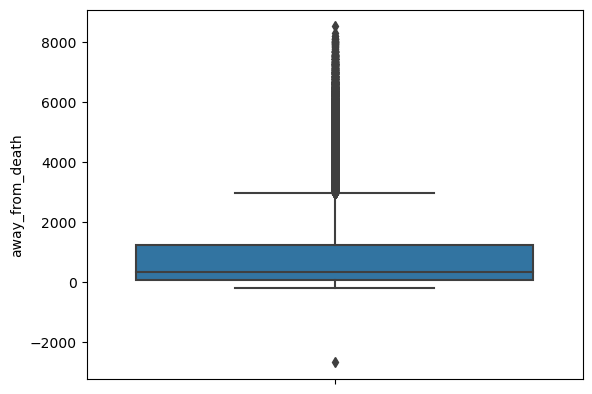

In [33]:
sns.boxplot(data= tidy_dataset, y ='away_from_death')

In [34]:
print(len(tidy_dataset[tidy_dataset["away_from_death"] < 900]))
print(len(tidy_dataset[tidy_dataset["away_from_death"] > 900]))

41956
19027


In [35]:
tidy_dataset['died_within_900days'] = [0] * len(tidy_dataset)

def age_category(data):
    data.loc[(data['away_from_death'] < 900), 'died_within_900days'] = 1
    data.loc[(data['away_from_death'] >= 900), 'died_within_900days'] = 0
    data.loc[(data['away_from_death'].isna()), 'died_within_900days'] = 0
    return data
tidy_dataset = age_category(tidy_dataset)
tidy_dataset

,Internalpatientid,num_stays,stay_length,num_unique_units,num_transfers,num_cvd_readmission,Died,AO,CVD,unique_admitting_specialty,...,Others_Specialty,Rehab,Gerontology,next_readmission_time,Discharge date,readmission within 300 days,Age at death,Death date,away_from_death,died_within_900days
0,1,3,14.16,2,0,0,0,0,0,3,...,0,0,0,2352.34,2016-07-22 21:36:24,0,NaN,NaT,NaN,0
1,2,21,71.17,5,2,9,0,0,1,9,...,0,9,1,0.00,2023-09-12 02:28:10,0,NaN,NaT,NaN,0
2,3,1,1.83,1,0,0,0,0,1,1,...,0,1,0,885.57,2002-03-30 18:12:14,0,82.284691,2005-10-12 01:18:21,1291.0,0
3,4,1,7.15,1,0,0,0,0,1,1,...,0,1,0,0.00,2015-02-23 09:46:15,0,84.190359,2015-02-24 13:49:53,1.0,1
4,5,1,1.04,1,0,0,0,0,1,1,...,0,0,0,26.75,2004-10-02 06:54:56,1,76.506124,2004-11-04 23:43:20,33.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84531,169055,1,6.47,1,0,0,0,0,1,1,...,0,0,0,0.00,2002-04-12 16:51:53,0,68.572433,2011-12-06 05:22:50,3524.0,0
84532,169057,28,94.63,3,2,12,0,0,1,11,...,0,13,12,2.21,2025-02-12 17:23:04,1,NaN,NaT,NaN,0
84533,169060,7,41.68,2,0,4,0,0,1,5,...,0,1,1,51.81,2017-02-08 09:55:03,1,71.832486,2017-10-15 18:34:11,249.0,1
84534,169062,11,135.67,4,0,0,0,1,0,6,...,0,0,0,89.89,2005-06-04 03:34:07,1,74.181399,2005-10-14 07:13:53,132.0,1


In [36]:
print(len(tidy_dataset[tidy_dataset["died_within_900days"] == 0]))
print(len(tidy_dataset[tidy_dataset["died_within_900days"] == 1]))

42580
41956


In [37]:
tidy_dataset.to_csv("inpatient_full_simple.csv")